In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
import sklearn.datasets
import sklearn.neighbors

X_train = np.load('/kaggle/input/intent-detection/X_train.npy')
X_test = np.load('/kaggle/input/intent-detection/X_test.npy')
Y_train = pd.read_csv('/kaggle/input/intent-detection/y_train.csv').Predicted.to_numpy()

In [2]:
X_train.shape
#768 features

(1663, 768)

In [3]:
Y_train.shape
#1663 labels

(1663,)

In [4]:
X_test.shape

(713, 768)

In [5]:
feat_col = [f'feat{i}' for i in range(X_test.shape[1])]
X_train_df = pd.DataFrame(X_train, columns = feat_col)
Y_train_df = pd.DataFrame(Y_train,columns = ["Target"])
XY_train_df = pd.concat([X_train_df, Y_train_df],axis = 1)
X_test_df = pd.DataFrame(X_test, columns=feat_col)


In [6]:
XY_train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat759,feat760,feat761,feat762,feat763,feat764,feat765,feat766,feat767,Target
0,-0.064713,0.020554,-0.069173,-0.028174,-0.063835,-0.054158,-0.056317,0.001036,-0.038301,-0.027957,...,-0.049167,-0.019388,-0.045488,-0.051312,-0.022920,-0.034919,-0.020073,-0.052884,0.023714,8
1,-0.006381,0.007817,-0.022947,0.039866,-0.052437,0.011669,-0.051878,-0.026330,0.040994,-0.052231,...,0.014502,0.007691,-0.025002,-0.004711,0.003568,-0.010177,-0.066476,-0.012160,0.017803,44
2,0.003579,-0.009228,-0.062796,0.021353,-0.067594,-0.019499,0.029121,-0.013298,0.009264,-0.037961,...,0.038328,-0.005684,-0.033541,0.020269,-0.022111,-0.066562,0.012762,0.018555,0.002605,11
3,-0.043724,-0.011425,-0.051950,0.014659,-0.046709,-0.002156,-0.033904,0.004498,0.044775,-0.030488,...,-0.036184,-0.055876,0.012600,-0.016588,0.053944,-0.066483,-0.008629,-0.001444,0.025507,24
4,-0.019088,0.067039,-0.032487,-0.037979,0.014185,-0.007818,-0.059850,0.012668,-0.032715,0.009354,...,-0.065700,-0.043206,0.047978,-0.050414,0.024116,-0.046814,-0.002983,0.050728,0.038645,5


In [7]:
Y_train_df.head()

,Target
0,8
1,44
2,11
3,24
4,5


In [8]:
X_train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat758,feat759,feat760,feat761,feat762,feat763,feat764,feat765,feat766,feat767
0,-0.064713,0.020554,-0.069173,-0.028174,-0.063835,-0.054158,-0.056317,0.001036,-0.038301,-0.027957,...,0.042405,-0.049167,-0.019388,-0.045488,-0.051312,-0.022920,-0.034919,-0.020073,-0.052884,0.023714
1,-0.006381,0.007817,-0.022947,0.039866,-0.052437,0.011669,-0.051878,-0.026330,0.040994,-0.052231,...,0.059453,0.014502,0.007691,-0.025002,-0.004711,0.003568,-0.010177,-0.066476,-0.012160,0.017803
2,0.003579,-0.009228,-0.062796,0.021353,-0.067594,-0.019499,0.029121,-0.013298,0.009264,-0.037961,...,-0.041462,0.038328,-0.005684,-0.033541,0.020269,-0.022111,-0.066562,0.012762,0.018555,0.002605
3,-0.043724,-0.011425,-0.051950,0.014659,-0.046709,-0.002156,-0.033904,0.004498,0.044775,-0.030488,...,-0.007816,-0.036184,-0.055876,0.012600,-0.016588,0.053944,-0.066483,-0.008629,-0.001444,0.025507
4,-0.019088,0.067039,-0.032487,-0.037979,0.014185,-0.007818,-0.059850,0.012668,-0.032715,0.009354,...,0.038573,-0.065700,-0.043206,0.047978,-0.050414,0.024116,-0.046814,-0.002983,0.050728,0.038645


In [9]:
X_test_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat758,feat759,feat760,feat761,feat762,feat763,feat764,feat765,feat766,feat767
0,-0.028341,-0.013976,0.027482,0.018902,-0.061030,-0.010846,-0.036913,-0.034498,0.058866,-0.014550,...,0.060303,-0.033084,-0.039746,0.038668,-0.024701,0.000322,-0.077359,0.024810,-0.036909,0.045314
1,-0.014473,-0.037281,0.017812,0.027492,0.020230,-0.009877,-0.054037,0.025131,0.029863,-0.029646,...,-0.002850,-0.043410,-0.012185,-0.049657,-0.005346,-0.014185,0.005000,-0.007676,0.025819,0.036317
2,-0.022636,-0.001754,-0.009812,-0.030182,-0.061902,0.032183,-0.079847,-0.030968,0.012289,0.009093,...,-0.032143,0.016097,-0.052526,0.046948,-0.007215,0.029919,-0.027418,-0.051822,0.014895,-0.043391
3,-0.040850,-0.023058,-0.033664,0.016514,-0.075332,-0.065355,-0.057857,0.007287,-0.013866,-0.010538,...,-0.054553,0.036248,-0.065568,0.011958,0.034914,-0.029956,-0.060300,-0.025076,0.040312,0.006233
4,0.005932,-0.038425,0.048765,0.021749,-0.065592,-0.034451,0.007840,-0.012663,0.003260,-0.010410,...,-0.029770,-0.043370,-0.063726,-0.004431,-0.012578,-0.062581,-0.068841,-0.040079,-0.040869,-0.014907


In [10]:
missing_data = XY_train_df.isnull()
for col in missing_data.columns.values.tolist():
    sum = missing_data[[col]].astype(bool).sum(axis=0)
    if sum[0] != 0:
        print(sum)
        
#no missing data

In [11]:
XY_train_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1658    False
1659    False
1660    False
1661    False
1662    False
Length: 1663, dtype: bool

In [12]:
XY_train_df.duplicated().sum()
#31 duplicate rows found

31

In [13]:
XY_train_df = XY_train_df.drop_duplicates()

In [14]:
X_test_df.duplicated().sum()

10

In [15]:
X_test_df = X_test_df.drop_duplicates()

In [16]:
import umap
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_neighbors = 50)

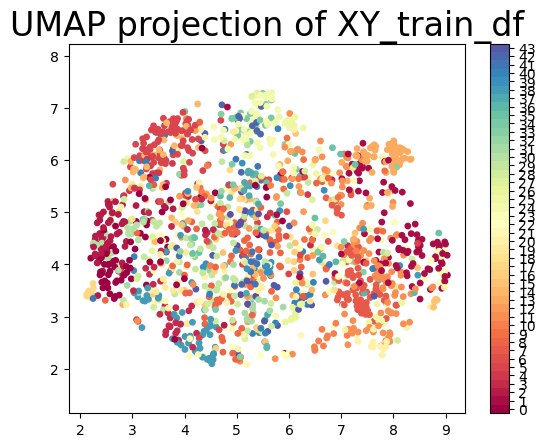

In [17]:
embedding = reducer.fit_transform(XY_train_df.iloc[:,:-1])

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c= XY_train_df.iloc[:,-1],
    cmap = 'Spectral', s= 15
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of XY_train_df', fontsize=24);
plt.colorbar(boundaries=np.arange(45)-0.5).set_ticks(np.arange(44))

In [18]:
outlier_scores = sklearn.neighbors.LocalOutlierFactor(novelty=False).fit_predict(embedding)

In [19]:
outlying_digits = XY_train_df[outlier_scores == -1]
outlying_digits.shape

(1, 769)

In [20]:
XY_train_df.loc[:, XY_train_df.columns == 'Target']

,Target
0,8
1,44
2,11
3,24
4,5
...,...
1658,20
1659,8
1660,34
1661,37


In [21]:
# Define the model
model = Sequential()
model.add(Dense(units=512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=45, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(XY_train_df.loc[:, XY_train_df.columns != 'Target'], XY_train_df.loc[:, XY_train_df.columns == 'Target'], validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
21/21 [==============================] - 2s 23ms/step - loss: 3.6317 - accuracy: 0.0904 - val_loss: 3.3446 - val_accuracy: 0.0948
Epoch 2/50
21/21 [==============================] - 0s 11ms/step - loss: 3.1690 - accuracy: 0.2291 - val_loss: 2.8365 - val_accuracy: 0.3609
Epoch 3/50
21/21 [==============================] - 0s 11ms/step - loss: 2.6666 - accuracy: 0.3441 - val_loss: 2.3907 - val_accuracy: 0.3914
Epoch 4/50
21/21 [==============================] - 0s 11ms/step - loss: 2.2822 - accuracy: 0.4015 - val_loss: 2.1293 - val_accuracy: 0.4404
Epoch 5/50
21/21 [==============================] - 0s 11ms/step - loss: 1.9803 - accuracy: 0.4452 - val_loss: 1.9837 - val_accuracy: 0.4862
Epoch 6/50
21/21 [==============================] - 0s 11ms/step - loss: 1.7643 - accuracy: 0.5042 - val_loss: 1.8275 - val_accuracy: 0.4893
Epoch 7/50
21/21 [==============================] - 0s 11ms/step - loss: 1.5441 - accuracy: 0.5701 - val_loss: 1.6704 - val_accuracy: 0.5352
Epoch 8/50
21

In [22]:
y_pred = model.predict(X_test_df)

22/22 [==============================] - 0s 3ms/step


In [23]:
y_pred

array([[9.32438299e-03, 8.75369296e-05, 1.26438745e-05, ...,
        1.07393712e-08, 3.45035374e-07, 8.12368853e-06],
       [1.15996785e-02, 6.57541648e-07, 4.29150416e-03, ...,
        2.38141307e-04, 6.76852418e-04, 6.20499207e-03],
       [6.45217369e-07, 1.64114333e-10, 1.62788290e-08, ...,
        2.81255619e-09, 1.71656234e-06, 1.35690883e-07],
       ...,
       [2.90425306e-09, 5.20461413e-07, 1.33632047e-16, ...,
        1.02383284e-08, 5.46638602e-11, 1.88667717e-18],
       [9.57669377e-01, 3.98479277e-10, 4.80527943e-03, ...,
        4.15438628e-10, 9.68379977e-12, 3.91641519e-09],
       [8.13527673e-04, 5.44044440e-07, 6.19987957e-04, ...,
        1.27329855e-04, 1.04276114e-06, 9.76289357e-07]], dtype=float32)